File to train on the toy_df.csv (that came from the 001_Forbes Dataset)

In [31]:
import os
import ast
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import random
import pandas as pd
from transformers import TapasConfig, TapasForQuestionAnswering, TapasTokenizer, AdamW
warnings.filterwarnings("ignore")

In [17]:
# load in tokenizer
tokenizer = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")
base_tokenizer = TapasTokenizer.from_pretrained("google/tapas-base")

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Function to convert the string representation to a list of tuples
def parse_answer_coords(coords_str):
    try:
        # Safely evaluate the string to a Python object
        coords = ast.literal_eval(coords_str)
        
        # Ensure the result is a list of tuples with integers
        if isinstance(coords, list) and all(
            isinstance(coord, (tuple, list)) and len(coord) == 2 and all(isinstance(x, int) for x in coord)
            for coord in coords
        ):
            return [tuple(coord) for coord in coords]  # Convert lists to tuples if needed
        else:
            raise ValueError(f"Invalid format for answer_coords: {coords_str}")
    except (ValueError, SyntaxError) as e:
        raise ValueError(f"Error parsing answer_coords: {coords_str}. Details: {e}")

In [21]:
# class to tokenizer dataset
class TableDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = self.process_answer_coords_column(data)
        self.tokenizer = tokenizer
        self.table_csv_path = 'data/'

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        table = pd.read_csv(self.table_csv_path + item.dataset).astype(
            str
        )  # be sure to make your table data text only

        encoding = self.tokenizer(
            table=table,
            queries=item.question,
            answer_coordinates=item.answer_coords,
            answer_text=item.sample_answer,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        # remove the batch dimension which the tokenizer adds by default
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        # add the float_answer which is also required (weak supervision for aggregation case)
        encoding["float_answer"] = torch.tensor(item.float_answer)
        return encoding

    def __len__(self):
        return len(self.data)
    
    # change answer_coords from strings
    def process_answer_coords_column(self, data, column_name="answer_coords"):
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' does not exist in the dataset.")

        def parse_answer_coords(coords_str):
            try:
                coords = ast.literal_eval(coords_str)
                if isinstance(coords, list) and all(
                    isinstance(coord, (tuple, list)) and len(coord) == 2 and all(isinstance(x, int) for x in coord)
                    for coord in coords
                ):
                    return [tuple(coord) for coord in coords]
                else:
                    raise ValueError(f"Invalid format for answer_coords: {coords_str}")
            except (ValueError, SyntaxError) as e:
                raise ValueError(f"Error parsing answer_coords: {coords_str}. Details: {e}")
        data[column_name] = data[column_name].apply(parse_answer_coords)
        return data

In [42]:
# load in toy_df, tokenize and place in dataloader
csv_path = 'data/toy_df_v2.csv'
df = pd.read_csv(csv_path)

datasets = list(set(df['dataset']))
train_datasets = datasets[:len(datasets) - 2]
dev_datasets = datasets[len(datasets) - 2:]

train_df = df[df['dataset'].isin(train_datasets)]
dev_df = df[df['dataset'].isin(dev_datasets)]

# load train dataloader
train_dataset = TableDataset(train_df, tokenizer)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

# load dev dataloader
dev_dataset = TableDataset(dev_df, tokenizer) # change this so I dont need answer coordinates
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=8)

# get test datasets
test_data = pd.read_csv('data/test.csv')
test_dfs = list(set(test_data['dataset']))

In [23]:
# load in WTQ model (from TAPAS documentation)
config = TapasConfig(
    num_aggregation_labels=4,
    use_answer_as_supervision=True,
    answer_loss_cutoff=0.664694,
    cell_selection_preference=0.207951,
    huber_loss_delta=0.121194,
    init_cell_selection_weights_to_zero=True,
    select_one_column=True,
    allow_empty_column_selection=False,
    temperature=0.0352513,
)

model_wtq = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq", config=config) # leave as is
model_finetune = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq", config=config) # finetune
optimizer = AdamW(model_finetune.parameters(), lr=5e-5)

Some weights of TapasForQuestionAnswering were not initialized from the model checkpoint at google/tapas-base and are newly initialized: ['column_output_bias', 'column_output_weights', 'output_bias', 'output_weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            total_loss += outputs.loss.item()
            num_batches += 1
    return total_loss / num_batches if num_batches > 0 else float('inf')

# Function to evaluate the model and calculate dev loss
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            total_loss += outputs.loss.item()
            num_batches += 1
    return total_loss / num_batches if num_batches > 0 else float('inf')

def train_model(
    model, 
    train_dataloader, 
    dev_dataloader, 
    optimizer, 
    device, 
    epochs, 
    save_path, 
    description="Training Parameters Description"
):
    best_dev_loss = float('inf')
    model.to(device)
    
    save_path = 'models/' + save_path
    train_losses = [] 
    dev_losses = []    
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        epoch_train_loss = 0

        # Training loop
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss)
        
        
        # Evaluate on dev set
        epoch_dev_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(dev_dataloader, desc="Validation"):
                inputs = {key: value.to(device) for key, value in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                epoch_dev_loss += loss.item()
        dev_losses.append(epoch_dev_loss)
        
        print(f"Training loss for epoch {epoch + 1}: {epoch_train_loss:.4f}")
        print(f"Validation loss for epoch {epoch + 1}: {epoch_dev_loss:.4f}")
        
    
    # Save final model
    model.save_pretrained(save_path)
    print(f"fine-tuned model saved to {save_path}")
    
    # Plot losses ans save
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), dev_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot with description
    plt.savefig(f"{save_path}/training_loss_plot.png")
    print(f"Loss plot saved")
    
    # Save training description
    with open(f"{save_path}/training_description.txt", "w") as desc_file:
        desc_file.write(description)
        desc_file.write(f"\nEpochs: {epochs}")
        desc_file.write(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
        desc_file.write(f"\nFinal Validation Loss: {dev_losses[-1]:.4f}")
    
    print('Done Training')
    return model

Epoch 1/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  25%|████████▌                         | 3/12 [01:35<04:44, 31.66s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [03:04<03:00, 30.12s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [04:26<01:24, 28.00s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 1: 25.7405


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 1: 3.1657
Epoch 2/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training:  83%|███████████████████████████▌     | 10/12 [04:33<00:56, 28.31s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

Training loss for epoch 2: 18.4491


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 2: 3.3462
Epoch 3/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:57<03:07, 31.18s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training:  83%|███████████████████████████▌     | 10/12 [04:57<00:59, 29.99s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

Training loss for epoch 3: 12.8499


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 3: 2.5249
Epoch 4/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  25%|████████▌                         | 3/12 [01:28<04:22, 29.20s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:46<02:40, 26.73s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [04:06<01:20, 26.67s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 4: 8.5212


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 4: 2.6898
Epoch 5/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:33<02:33, 25.54s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [03:54<01:19, 26.48s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 5: 7.9137


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 5: 3.8299
Epoch 6/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training:  25%|████████▌                         | 3/12 [01:21<04:05, 27.32s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:44<02:44, 27.49s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [04:06<01:21, 27.31s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 6: 5.3138


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 6: 3.4857
Epoch 7/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:31<02:28, 24.73s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [03:51<01:18, 26.27s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 7: 5.0322


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 7: 4.3898
Epoch 8/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training:  25%|████████▌                         | 3/12 [01:21<04:06, 27.39s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:42<02:42, 27.01s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [04:02<01:20, 26.81s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 8: 9.4162


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 8: 9.3358
Epoch 9/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:37<02:38, 26.37s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [03:57<01:20, 26.73s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 9: 7.1892


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 9: 4.6020
Epoch 10/10


Training:   0%|                                          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  50%|█████████████████                 | 6/12 [02:43<02:41, 26.92s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
Training:  75%|█████████████████████████▌        | 9/12 [04:03<01:20, 26.70s/it]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Training loss for epoch 10: 5.6286


Validation:   0%|                                         | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as posi

/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/opt/anaconda3/envs/cs375/lib/python3.11/site-packages/transformers/models/tapas/tokenization_tapas.py:2673: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

Validation loss for epoch 10: 4.2459
fine-tuned model saved to models/wtq_finetune
Loss plot saved
Done Training


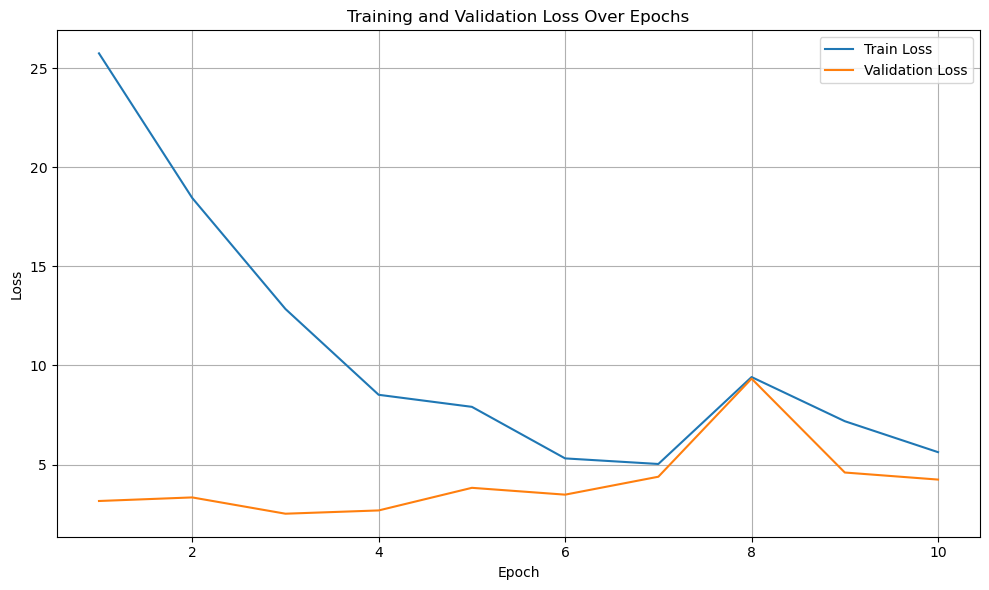

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
description = 'Normal Question format, toy_df_v2.csv for all cell annotation'

# Fine-tune model
model_finetune = train_model(
    model=model_finetune,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    device=device,
    epochs=10,
    save_path="wtq_finetune",
    description = description
)

In [74]:
# Inference
def inference(test_data, test_dfs, model):
    num_none = 0
    num_agg = 0
    num_correct = 0
    num_correct_none = 0
    num_correct_agg = 0
    total_questions = 0
    num_number = 0
    num_number_correct = 0
    num_category = 0
    num_category_correct = 0
    
    for file in test_dfs:
        print('#################### test on:', file,'####################')
        table = pd.read_csv(f'data/{file}').astype(str)
        df = test_data[test_data['dataset'] == file]
        queries = list(df['question'])
        inputs = tokenizer(
            table = table,
            queries = queries,
            padding="max_length",
            return_tensors="pt",
            truncation = True
        )

        outputs = model(**inputs)
        predicted_answer_coordinates, predicted_aggregation_indices = tokenizer.convert_logits_to_predictions(
            inputs, outputs.logits.detach(), outputs.logits_aggregation.detach()
        )

        # print results:
        id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3: "COUNT"}
        aggregation_predictions_string = [id2aggregation[x] for x in predicted_aggregation_indices]

        answers = []
        for coordinates in predicted_answer_coordinates:
            if len(coordinates) == 1:
                # only a single cell:
                answers.append(table.iat[coordinates[0]])
            else:
                # multiple cells
                cell_values = []
                for coordinate in coordinates:
                    cell_values.append(table.iat[coordinate])
                answers.append(", ".join(cell_values))

        i = 0
        real_answers = list(df['sample_answer'])
        answer_type = list(df['type'])
        for query, answer, predicted_agg in zip(queries, answers, aggregation_predictions_string):
            total_questions += 1 
            print(query)
            
            print('Indeded type: ', answer_type[i])
            if answer_type[i] == 'number':
                num_number += 1
            else:
                num_category += 1
                
            if predicted_agg == "NONE":
                print("     Predicted answer: " + answer)
                print("     Real answer: ", real_answers[i])
                if str(answer) == str(real_answers[i]):
                    num_correct += 1
                    num_correct_none += 1
                    if answer_type[i] == 'number':
                        num_number_correct += 1
                    else:
                        num_category_correct += 1
                    
                i += 1
                num_none += 1

            else:
                print("     Predicted Cells: " + predicted_agg + " > " + answer)
                if predicted_agg == 'COUNT':
                    count = answer.split(',')
                    answer = len(list(set(count)))
                    print('     Predicted Count: ', answer)

                if predicted_agg == 'AVERAGE':
                    total = 0
                    a = answer.split(',')
                    try:
                        a = [float(elem) for elem in a]
                    except:
                        print('     Predicted Average: Error')
                        answer = None
                        i += 1
                        continue
                    num = len(a)
                    answer = 0
                    for elem in a:
                        answer += (elem/num)  
                    print('     Predicted Average:', answer)
                if predicted_agg == 'SUM':
                    s = answer.split(',')
                    s = [float(elem) for elem in s]
                    answer = 0
                    for elem in s:
                        answer += elem
                    print('     Predicted Sum:', answer)

                print("     Real answer: ", str(real_answers[i]))
                if str(answer) == str(real_answers[i]):
                        num_correct += 1
                        num_correct_agg += 1
                i += 1
                num_agg += 1

    print("")
    print('Number of Questions: ', total_questions)
    print('Overall Accuracy: ', num_correct/total_questions)
    print('Number Accuracy: ', num_number_correct/num_number)
    print('Category Accuracy: ', num_category_correct/num_category)
    try:
        print('NONE Accuracy:', num_correct_none/num_none)
    except:
        print('***** No questions with predicted Aggregation Tag NONE ***** ')
    try:
        print('Agg Accuracy:', num_correct_agg/num_agg)
    except:
        print('***** No questions with predicted Aggregation Tag SUM, AVERAGE, or COUNT ***** ')
    print("")

In [72]:
# inference on finetuned model - test data
inference(test_data, test_dfs, model_finetune)

#################### test on: 038_Stroke.csv ####################
How many people in the dataset have a stroke?
Indeded type:  number
     Predicted Cells: COUNT > 5
     Predicted Count:  1
     Real answer:  1
What is the average age of people who smoke?
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
What is the highest glucose level recorded in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  143.43
How many unique 'work_type' categories are there in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  4
What is the most common work type among stroke patients?
Indeded type:  category
     Predicted answer: 
     Real answer:  Self-employed
What is the smoking status of the youngest person in the dataset?
Indeded type:  category
     Predicted answer: 
     Real answer:  Unknown
What is the residence type of the person with the hi

In [73]:
# inference on wtq model - test data
inference(test_data, test_dfs, model_wtq)

#################### test on: 038_Stroke.csv ####################
How many people in the dataset have a stroke?
Indeded type:  number
     Predicted Cells: COUNT > 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
     Predicted Count:  20
     Real answer:  1
What is the average age of people who smoke?
Indeded type:  number
     Predicted Cells: AVERAGE > 69.0, 26.0, 56.0
     Predicted Average: 50.33333333333333
     Real answer:  50.333333333333336
What is the highest glucose level recorded in the dataset?
Indeded type:  number
     Predicted answer: 5
     Real answer:  143.43
How many unique 'work_type' categories are there in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > Self-employed, Self-employed, Private, Self-employed, Private, Self-employed, children, Private, children, Self-employed, Govt_job, Self-employed, Private, children, Govt_job, children, Private, Govt_job, Private
     Predicted Count:  5
     Real answer:  4
What is the most

How many songs were produced in 1965?
Indeded type:  number
     Predicted Cells: COUNT > game of love, i like it like that
     Predicted Count:  2
     Real answer:  2
In which year was the song with the highest rank produced?
Indeded type:  number
     Predicted answer: 2008
     Real answer:  2008
What's the rank of the song with the longest lyrics?
Indeded type:  number
     Predicted Cells: AVERAGE > 40
     Predicted Average: 40.0
     Real answer:  64
How many unique artists are there in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > alicia keys, christina aguilera, mariah carey, wayne fontana  the mindbenders, fall out boy, blink 182, gladys knight  the pips, the beatles, leann rimes, flo rida, the carpenters, meat loaf, keith sweat, barbra streisand, the dave clark five, dirty vegas, aerosmith, the who, lady antebellum, don henley
     Predicted Count:  20
     Real answer:  20
Who is the artist of the song with the highest rank?
Indeded type:  category
    

In [75]:
# test to see if finetuning was effective (for bugs) on train set
# inference on finetuned model - train data
inference(train_df, train_datasets, model_finetune)

# inference on wtq model - train data
inference(train_df, train_datasets, model_wtq)

#################### test on: 010_ECommerce.csv ####################
What is the average age of the reviewers?
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
What's the highest number of positive feedback received for a review?
Indeded type:  number
     Predicted answer: 
     Real answer:  19
What is the most common rating given by reviewers?
Indeded type:  number
     Predicted answer: Dresses, Blouses
     Real answer:  5
How many unique clothing items are there in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 1095, 903, 830, 1047, 1110, 820, 1059, 1092, 22, 394, 1081, 1094, 1025, 834, 829
     Predicted Count:  15
     Real answer:  20
Which department has the most reviews?
Indeded type:  category
     Predicted answer: Dresses
     Real answer:  Dresses
Which class of clothing is most commonly reviewed?
Indeded type:  category
     Predicted answer: 
     Real answer:  Dresses
Which division is most commonly mentioned in th

How many unique states are represented in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > AR, WY, MO, IL, IL, IL, TX, KS, KS, KS, OK, IA, TX
     Predicted Count:  8
     Real answer:  12
What is the highest magnitude of tornado recorded in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  2
What is the longest length of a tornado path in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  72.2
What is the maximum number of injuries caused by a single tornado?
Indeded type:  number
     Predicted Cells: COUNT > 5, 2, 3
     Predicted Count:  3
     Real answer:  3
Which state has experienced the most tornadoes?
Indeded type:  category
     Predicted answer: 
     Real answer:  IL
In which month do most tornadoes occur?
Indeded type:  category
     Predicted answer: 5, 6, 3
     Real answer:  6
On what date did the most destructive tornado (by injuries) 

What is the maximum fare amount charged for a trip?
Indeded type:  number
     Predicted Cells: AVERAGE > 40.8
     Predicted Average: 40.8
     Real answer:  40.8
How many unique pickup locations are in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 23.15, 12.31, 45.8, 20.41, 24.87, 14.85, 20.16, 21.36, 25.2, 16.32, 17.2, 33.2, 39.9, 18.04, 12.6, 21.0, 13.25, 24.0, 13.4, 16.45
     Predicted Count:  20
     Real answer:  18
What is the average tip amount given by passengers?
Indeded type:  number
     Predicted Cells: AVERAGE > 3.85, 1.51, 0.0, 4.71, 4.97, 2.95, 3.36, 3.56, 4.2, 2.72, 0.0, 5.5, 6.0, 1.64, 0.0, 3.5, 1.75, 4.0, 2.2, 2.15
     Predicted Average: 2.928499999999999
     Real answer:  1.5
Which payment type is the most common in the dataset?
Indeded type:  category
     Predicted answer: 2
     Real answer:  1
Which vendor has the most trips recorded?
Indeded type:  category
     Predicted answer: 
     Real answer:  2
What is the most common drop-off loca

How many unique states are represented in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0
     Predicted Count:  3
     Real answer:  12
What is the highest magnitude of tornado recorded in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 3
     Predicted Average: 3.0
     Real answer:  2
What is the longest length of a tornado path in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 4.3, 4.7
     Predicted Count:  2
     Real answer:  72.2
What is the maximum number of injuries caused by a single tornado?
Indeded type:  number
     Predicted Cells: COUNT > 4.3, 4.7
     Predicted Count:  2
     Real answer:  3
Which state has experienced the most tornadoes?
Indeded type:  category
     Predicted answer: 
     Real answer:  IL
In which month do most tornadoes occur?
Indeded type:  category
     Predicted answer: 2016-05-24
     Real answer:  6
On what date did the most destructive tornado (by in

Report accuracy train and dev (x-axis epoch, and y-axis loss) -> jsut show that I am thinking about overfitting
Run error analysis on answer length by accuracy 
fix and and train data split
talk about if I had more time... this is what I would have done

Observations 
- the aggregation operator is often wrong, but still gets the right answer
    - for example when looking for a max value, chooses the AVERAGE operator, but only on one cell so still correct
- my finetuned model (on toy_df_vw) did not work I do not know why
    - gets almost nothing right 
    - when I test on my train set
    - I think that adding the extra coordinates is screwing with the model
            - Number of Questions:  89
            - Overall Accuracy:  0.10112359550561797
            - Number Accuracy:  0.022727272727272728
            - Category Accuracy:  0.08888888888888889
            - NONE Accuracy: 0.09259259259259259
            - Agg Accuracy: 0.12903225806451613
            
    - the non-fintuned wtq version was this:
            - Number of Questions:  89
            - Overall Accuracy:  0.23595505617977527
            - Number Accuracy:  0.022727272727272728
            - Category Accuracy:  0.24444444444444444
            - NONE Accuracy: 0.2727272727272727
            - Agg Accuracy: 0.20454545454545456